In [121]:
!pip install neuralprophet

In [122]:
from neuralprophet import NeuralProphet

In [123]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import os

In [124]:
# Mount Google Drive
drive.mount('/content/drive')

# Path of folder
folder_path = '/content/drive/MyDrive/Colab Notebooks/2024_09_13/'

# Get list of all CSV files in the folder
csv_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')]

# Initialize an empty list to hold the dataframes
dfs = []

# Loop through the CSV files and read each one into a dataframe
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate all dataframes into a single dataframe
data = pd.concat(dfs, ignore_index=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [125]:
data_selected = data[['Alarm Name', 'Alarm Location Info', 'First Occurred On', 'Site ID', 'Vendor', 'Domain', 'Device Type']]
data_selected.head(10)

,Alarm Name,Alarm Location Info,First Occurred On,Site ID,Vendor,Domain,Device Type
0,Cell Capability Degraded,"eNodeB Function Name=Dandagamuwa-KU0436-BHP, L...",2024-09-12 15:37:11,KU0436,HUAWEI,Access,eNodeB
1,Cell Out of Service,"Site Index=328, Cell Index=1520, Alarm Cause=O...",2024-09-07 12:06:37,KU0436,HUAWEI,Access,eGBTS
2,Cell Out of Service,"Site Index=328, Cell Index=1519, Alarm Cause=O...",2024-09-07 12:06:37,KU0436,HUAWEI,Access,eGBTS
3,Cell Out of Service,"Site Index=328, Cell Index=1521, Alarm Cause=O...",2024-09-07 12:06:37,KU0436,HUAWEI,Access,eGBTS
4,GSM Local Cell Unusable,"GBTS Function Name=Dandagamuwa-KU0436-DG, Loca...",2024-09-07 12:05:05,KU0436,HUAWEI,Access,eGBTS
5,GSM Local Cell Unusable,"GBTS Function Name=Dandagamuwa-KU0436-DG, Loca...",2024-09-07 10:46:25,KU0436,HUAWEI,Access,eGBTS
6,GSM Local Cell Unusable,"GBTS Function Name=Dandagamuwa-KU0436-DG, Loca...",2024-09-07 12:05:05,KU0436,HUAWEI,Access,eGBTS
7,GSM Local Cell Unusable,"GBTS Function Name=Dandagamuwa-KU0436-DG, Loca...",2024-09-07 12:05:05,KU0436,HUAWEI,Access,eGBTS
8,Cell Unavailable,"eNodeB Function Name=Dandagamuwa-KU0436-BHP, L...",2024-09-07 12:05:02,KU0436,HUAWEI,Access,eNodeB
9,Cell Unavailable,"eNodeB Function Name=Dandagamuwa-KU0436-BHP, L...",2024-09-07 12:05:02,KU0436,HUAWEI,Access,eNodeB


In [126]:
# prompt: create new distinct alarm codes for each unique alarm names in the Alarm Name column

# Create a dictionary to map unique alarm names to distinct alarm codes
alarm_name_to_code = {name: code for code, name in enumerate(data_selected['Alarm Name'].unique())}

# Create a new column 'Alarm Code' based on the mapping
data_selected['Alarm Code'] = data_selected['Alarm Name'].map(alarm_name_to_code)

# Display the updated dataframe
data_selected.head(10)


WARNING - (py.warnings._showwarnmsg) - <ipython-input-126-71dbd48bf588>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected['Alarm Code'] = data_selected['Alarm Name'].map(alarm_name_to_code)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected['Alarm Code'] = data_selected['Alarm Name'].map(alarm_name_to_code)



,Alarm Name,Alarm Location Info,First Occurred On,Site ID,Vendor,Domain,Device Type,Alarm Code
0,Cell Capability Degraded,"eNodeB Function Name=Dandagamuwa-KU0436-BHP, L...",2024-09-12 15:37:11,KU0436,HUAWEI,Access,eNodeB,0
1,Cell Out of Service,"Site Index=328, Cell Index=1520, Alarm Cause=O...",2024-09-07 12:06:37,KU0436,HUAWEI,Access,eGBTS,1
2,Cell Out of Service,"Site Index=328, Cell Index=1519, Alarm Cause=O...",2024-09-07 12:06:37,KU0436,HUAWEI,Access,eGBTS,1
3,Cell Out of Service,"Site Index=328, Cell Index=1521, Alarm Cause=O...",2024-09-07 12:06:37,KU0436,HUAWEI,Access,eGBTS,1
4,GSM Local Cell Unusable,"GBTS Function Name=Dandagamuwa-KU0436-DG, Loca...",2024-09-07 12:05:05,KU0436,HUAWEI,Access,eGBTS,2
5,GSM Local Cell Unusable,"GBTS Function Name=Dandagamuwa-KU0436-DG, Loca...",2024-09-07 10:46:25,KU0436,HUAWEI,Access,eGBTS,2
6,GSM Local Cell Unusable,"GBTS Function Name=Dandagamuwa-KU0436-DG, Loca...",2024-09-07 12:05:05,KU0436,HUAWEI,Access,eGBTS,2
7,GSM Local Cell Unusable,"GBTS Function Name=Dandagamuwa-KU0436-DG, Loca...",2024-09-07 12:05:05,KU0436,HUAWEI,Access,eGBTS,2
8,Cell Unavailable,"eNodeB Function Name=Dandagamuwa-KU0436-BHP, L...",2024-09-07 12:05:02,KU0436,HUAWEI,Access,eNodeB,3
9,Cell Unavailable,"eNodeB Function Name=Dandagamuwa-KU0436-BHP, L...",2024-09-07 12:05:02,KU0436,HUAWEI,Access,eNodeB,3


In [127]:
# prompt: print alarm name with code

for alarm_name, alarm_code in alarm_name_to_code.items():
  print(f"Alarm Name: {alarm_name}, Alarm Code: {alarm_code}")


Alarm Name: Cell Capability Degraded, Alarm Code: 0
Alarm Name: Cell Out of Service, Alarm Code: 1
Alarm Name: GSM Local Cell Unusable, Alarm Code: 2
Alarm Name: Cell Unavailable, Alarm Code: 3
Alarm Name: BBU CPRI Interface Error, Alarm Code: 4
Alarm Name: RF Unit DC Input Power Failure, Alarm Code: 5
Alarm Name: RF Unit VSWR Threshold Crossed, Alarm Code: 6
Alarm Name: RF Unit Maintenance Link Failure, Alarm Code: 7
Alarm Name: Theft Alarm, Alarm Code: 8
Alarm Name: Door Open Alarm, Alarm Code: 9
Alarm Name: System Dynamic Traffic Exceeding Licensed Limit, Alarm Code: 10
Alarm Name: Board Software Auto-Supply Failure, Alarm Code: 11
Alarm Name: Data Configuration Exceeding Licensed Limit, Alarm Code: 12
Alarm Name: SSU input cable abnormal (Check ASAP), Alarm Code: 13
Alarm Name: SCTP Link Congestion, Alarm Code: 14
Alarm Name: SCTP Link IP Address Unreachable, Alarm Code: 15
Alarm Name: Mains Failure, Alarm Code: 16
Alarm Name: Mains Failure Alarm, Alarm Code: 17
Alarm Name: AC Fail

In [128]:
# prompt: save those in a csv file

# Save the alarm name to code mapping to a CSV file
mapping_df = pd.DataFrame(list(alarm_name_to_code.items()), columns=['Alarm Name', 'Alarm Code'])
mapping_df.to_csv('/content/drive/MyDrive/Colab Notebooks/2024_09_13/alarm_name_to_code.csv', index=False)


In [129]:
# prompt: create new codes for vendor ,domain and device type also

# Create dictionaries to map unique values for Vendor, Domain, and Device Type to distinct codes
vendor_to_code = {vendor: code for code, vendor in enumerate(data_selected['Vendor'].unique())}
domain_to_code = {domain: code for code, domain in enumerate(data_selected['Domain'].unique())}
device_type_to_code = {device_type: code for code, device_type in enumerate(data_selected['Device Type'].unique())}

# Create new columns for Vendor Code, Domain Code, and Device Type Code based on the mappings
data_selected['Vendor Code'] = data_selected['Vendor'].map(vendor_to_code)
data_selected['Domain Code'] = data_selected['Domain'].map(domain_to_code)
data_selected['Device Type Code'] = data_selected['Device Type'].map(device_type_to_code)

# Display the updated dataframe
data_selected.head(10)

# Save the mappings to CSV files
vendor_mapping_df = pd.DataFrame(list(vendor_to_code.items()), columns=['Vendor', 'Vendor Code'])
vendor_mapping_df.to_csv('/content/drive/MyDrive/Colab Notebooks/2024_09_13/vendor_to_code.csv', index=False)

domain_mapping_df = pd.DataFrame(list(domain_to_code.items()), columns=['Domain', 'Domain Code'])
domain_mapping_df.to_csv('/content/drive/MyDrive/Colab Notebooks/2024_09_13/domain_to_code.csv', index=False)

device_type_mapping_df = pd.DataFrame(list(device_type_to_code.items()), columns=['Device Type', 'Device Type Code'])
device_type_mapping_df.to_csv('/content/drive/MyDrive/Colab Notebooks/2024_09_13/device_type_to_code.csv', index=False)


WARNING - (py.warnings._showwarnmsg) - <ipython-input-129-12440dfebf0a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected['Vendor Code'] = data_selected['Vendor'].map(vendor_to_code)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected['Vendor Code'] = data_selected['Vendor'].map(vendor_to_code)

WARNING - (py.warnings._showwarnmsg) - <ipython-input-129-12440dfebf0a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [130]:
data_selected.head()

,Alarm Name,Alarm Location Info,First Occurred On,Site ID,Vendor,Domain,Device Type,Alarm Code,Vendor Code,Domain Code,Device Type Code
0,Cell Capability Degraded,"eNodeB Function Name=Dandagamuwa-KU0436-BHP, L...",2024-09-12 15:37:11,KU0436,HUAWEI,Access,eNodeB,0,0,0,0
1,Cell Out of Service,"Site Index=328, Cell Index=1520, Alarm Cause=O...",2024-09-07 12:06:37,KU0436,HUAWEI,Access,eGBTS,1,0,0,1
2,Cell Out of Service,"Site Index=328, Cell Index=1519, Alarm Cause=O...",2024-09-07 12:06:37,KU0436,HUAWEI,Access,eGBTS,1,0,0,1
3,Cell Out of Service,"Site Index=328, Cell Index=1521, Alarm Cause=O...",2024-09-07 12:06:37,KU0436,HUAWEI,Access,eGBTS,1,0,0,1
4,GSM Local Cell Unusable,"GBTS Function Name=Dandagamuwa-KU0436-DG, Loca...",2024-09-07 12:05:05,KU0436,HUAWEI,Access,eGBTS,2,0,0,1


In [136]:
# prompt: filter only First Occurred On	,Site ID,	Alarm Code,	Vendor Code,	Domain Code,	Device Type Code

data_filtered = data_selected[['First Occurred On', 'Site ID', 'Alarm Code', 'Vendor Code', 'Domain Code', 'Device Type Code']]
data_filtered.head(50)


,First Occurred On,Site ID,Alarm Code,Vendor Code,Domain Code,Device Type Code
0,2024-09-12 15:37:11,KU0436,0,0,0,0
1,2024-09-07 12:06:37,KU0436,1,0,0,1
2,2024-09-07 12:06:37,KU0436,1,0,0,1
3,2024-09-07 12:06:37,KU0436,1,0,0,1
4,2024-09-07 12:05:05,KU0436,2,0,0,1
5,2024-09-07 10:46:25,KU0436,2,0,0,1
6,2024-09-07 12:05:05,KU0436,2,0,0,1
7,2024-09-07 12:05:05,KU0436,2,0,0,1
8,2024-09-07 12:05:02,KU0436,3,0,0,0
9,2024-09-07 12:05:02,KU0436,3,0,0,0


from matplotlib import pyplot as plt
_df_0['Alarm Code'].plot(kind='hist', bins=20, title='Alarm Code')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Domain Code'].plot(kind='hist', bins=20, title='Domain Code')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Device Type Code'].plot(kind='hist', bins=20, title='Device Type Code')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='Alarm Code', y='Domain Code', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Domain Code', y='Device Type Code', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Vendor Code']
  ys = series['Alarm Code']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('Vendor Code', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Vendor Code')
_ = plt.ylabel('Alarm Code')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Vendor Code']
  ys = series['Domain Code']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('Vendor Code', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Vendor Code')
_ = plt.ylabel('Domain Code')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Vendor Code']
  ys = series['Device Type Code']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('Vendor Code', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Vendor Code')
_ = plt.ylabel('Device Type Code')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Vendor Code']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Vendor Code'}, axis=1)
              .sort_values('Vendor Code', ascending=True))
  xs = counted['Vendor Code']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('Vendor Code', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Vendor Code')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_9['Alarm Code'].plot(kind='line', figsize=(8, 4), title='Alarm Code')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['Domain Code'].plot(kind='line', figsize=(8, 4), title='Domain Code')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['Device Type Code'].plot(kind='line', figsize=(8, 4), title='Device Type Code')
plt.gca().spines[['top', 'right']].set_visible(False)

In [132]:
# Import necessary library for categorical conversion
from tensorflow.keras.utils import to_categorical

# Step 1: Sorting the data by time to ensure chronological order
data_filtered = data_filtered.sort_values('First Occurred On')

# Step 2: Scaling the data (LSTMs work better with scaled data)
scaler = MinMaxScaler()

# Scale the features (except for 'First Occurred On' and 'Site ID')
scaled_features = scaler.fit_transform(data_filtered[['Alarm Code', 'Vendor Code', 'Domain Code', 'Device Type Code']])

# Add the scaled features back into the dataframe
data_filtered[['Alarm Code', 'Vendor Code', 'Domain Code', 'Device Type Code']] = scaled_features

# Step 3: Creating sequences for the LSTM model
def create_sequences(data, seq_length):
    sequences = []
    labels = []

    for i in range(len(data) - seq_length):
        sequence = data[i:i + seq_length]
        label = data[i + seq_length, 0]  # The target is the 'Alarm Code'
        sequences.append(sequence)
        labels.append(label)

    return np.array(sequences), np.array(labels)

# Define the sequence length (e.g., past 7 days)
sequence_length = 14

# Create sequences for LSTM (exclude 'First Occurred On' and 'Site ID')
X, y = create_sequences(scaled_features, sequence_length)

# Convert 'y' (alarm codes) to one-hot encoded format for classification
y_categorical = to_categorical(y, num_classes=len(np.unique(data_filtered['Alarm Code'])))

# Reshape X for LSTM (samples, timesteps, features)
X = X.reshape(X.shape[0], sequence_length, X.shape[2])

# Step 4: Split the data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y_categorical[:train_size], y_categorical[train_size:]

# Step 5: Build the LSTM model for classification
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_categorical.shape[1], activation='softmax'))  # Predicting the Alarm Code using softmax for classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 6: Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Step 7: Predict future unique alarms
# Use the last sequence from the test data to predict future unique alarms
last_sequence = X_test[-1].reshape(1, sequence_length, X_test.shape[2])

# Keep track of predicted alarms to ensure uniqueness
predicted_alarms = set()

# Predict future alarms for the next 7 days
future_alarms = []
for i in range(7):
    # Predict the next alarm code
    alarm_probabilities = model.predict(last_sequence)

    # Get the alarm code with the highest probability
    future_alarm_code = np.argmax(alarm_probabilities)

    # Ensure uniqueness of the alarm code
    while future_alarm_code in predicted_alarms:
        # Set the predicted alarm code to the next most probable alarm if already predicted
        alarm_probabilities[0][future_alarm_code] = -1  # Mask the already predicted code
        future_alarm_code = np.argmax(alarm_probabilities)

    # Add the predicted unique alarm to the list and set
    future_alarms.append(future_alarm_code)
    predicted_alarms.add(future_alarm_code)

    # Prepare the new timestep (use predicted alarm code and the other feature values from the last timestep)
    new_timestep = last_sequence[:, -1, :].copy()  # Copy the last timestep
    new_timestep[0, 0] = future_alarm_code  # Replace the 'Alarm Code' (index 0) with the predicted value

    # Update the sequence by adding the new timestep and removing the oldest timestep
    last_sequence = np.concatenate((last_sequence[:, 1:, :], new_timestep.reshape(1, 1, X_test.shape[2])), axis=1)

# Inverse transform the predicted alarm codes back to their original scale
future_alarms_original_scale = scaler.inverse_transform(np.concatenate([np.array(future_alarms).reshape(-1, 1), np.zeros((len(future_alarms), X_test.shape[2] - 1))], axis=1))[:, 0]

# Display the predicted future unique alarm codes
print(future_alarms_original_scale)


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)

  super().__init__(**kwargs)



Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 0.7955 - loss: 2.8439 - val_accuracy: 1.0000 - val_loss: 1.3886e-04
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 1.0000 - loss: 6.9820e-05 - val_accuracy: 1.0000 - val_loss: 2.3910e-05
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 1.0000 - loss: 2.2768e-05 - val_accuracy: 1.0000 - val_loss: 2.1590e-05
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 1.0000 - loss: 2.1053e-05 - val_accuracy: 1.0000 - val_loss: 2.0532e-05
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 1.0000 - loss: 2.0078e-05 - val_accuracy: 1.0000 - val_loss: 1.9616e-05
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 1.0000 - loss: 1.9135e-05 - val_accuracy: 1.0000 - val_loss: 1.8635e-05
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 1.0000 - loss: 1.8136e-05 - val_accuracy: 1.0000 - val_loss: 1.7688e-05
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accur

In [133]:
# prompt: trnsform the output in to the original form and original alarm names

# Load the alarm name to code mapping from the CSV file
alarm_code_to_name = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/2024_09_13/alarm_name_to_code.csv')
alarm_code_to_name = dict(zip(alarm_code_to_name['Alarm Code'], alarm_code_to_name['Alarm Name']))

# Convert the predicted alarm codes back to their original alarm names
predicted_alarm_names = [alarm_code_to_name.get(int(round(code)), 'Unknown Alarm') for code in future_alarms_original_scale]

# Display the predicted future alarm names
print(predicted_alarm_names)


['Cell Capability Degraded', 'Unknown Alarm', 'Unknown Alarm', 'Unknown Alarm', 'Unknown Alarm', 'Unknown Alarm', 'Unknown Alarm']


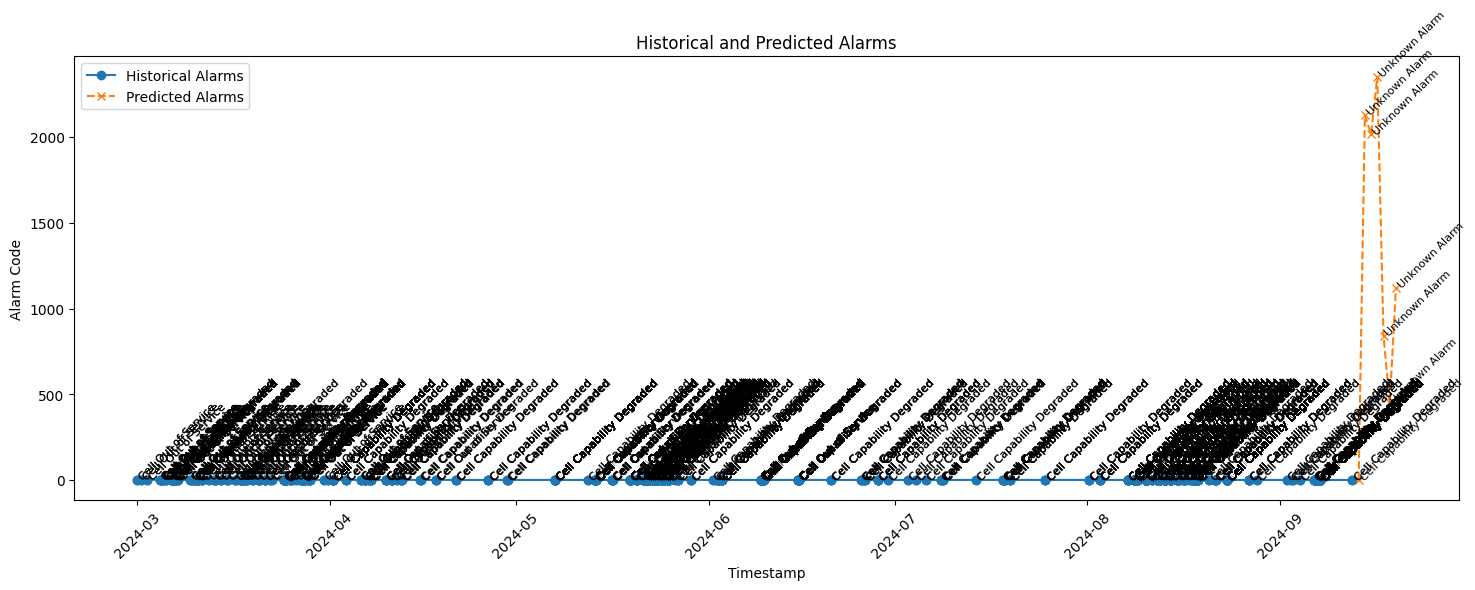

In [134]:
# prompt: plot the historical alarms and also the predicted alarms in a same plot with the actual alarm names

# Assuming 'data_filtered' has a 'First Occurred On' column and 'Alarm Code' column
# Assuming 'predicted_alarm_names' is a list of predicted alarm names
# Assuming 'alarm_code_to_name' is a dictionary mapping alarm codes to alarm names

# Convert 'First Occurred On' to datetime objects
data_filtered['First Occurred On'] = pd.to_datetime(data_filtered['First Occurred On'])

# Create a figure and axes
plt.figure(figsize=(15, 6))

# Plot historical alarms
plt.plot(data_filtered['First Occurred On'], data_filtered['Alarm Code'], label='Historical Alarms', marker='o')

# Generate future timestamps for the predicted alarms
future_timestamps = pd.date_range(start=data_filtered['First Occurred On'].max(), periods=len(predicted_alarm_names) + 1, freq='D')[1:]

# Plot predicted alarms
plt.plot(future_timestamps, future_alarms_original_scale, label='Predicted Alarms', marker='x', linestyle='--')

# Set labels and title
plt.xlabel('Timestamp')
plt.ylabel('Alarm Code')
plt.title('Historical and Predicted Alarms')

# Add a legend
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add annotations for alarm names
for i, (timestamp, alarm_code) in enumerate(zip(data_filtered['First Occurred On'], data_filtered['Alarm Code'])):
    alarm_name = alarm_code_to_name.get(int(round(alarm_code)), 'Unknown Alarm')
    plt.annotate(alarm_name, (timestamp, alarm_code), fontsize=8, rotation=45)

for i, (timestamp, alarm_code) in enumerate(zip(future_timestamps, future_alarms_original_scale)):
    alarm_name = alarm_code_to_name.get(int(round(alarm_code)), 'Unknown Alarm')
    plt.annotate(alarm_name, (timestamp, alarm_code), fontsize=8, rotation=45)

# Show the plot
plt.tight_layout()
plt.show()
